In [13]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


# We use Python's `functools.partial` to create a new function based on `fast_system` 
# with "eps" set to zero.
from functools import partial
from scipy.integrate import odeint
from sympy import symbols, Eq, solve, Function, Matrix, diff
#from scipy.integrate import solve_ivp


# Define the ODE systems
def fast_system(y, t, eps):
    x, y, z = y
    dxdt = -x
    dydt = 2 * y + eps * x
    dzdt = eps * (x**2 + 1)
    return [dxdt, dydt, dzdt]

# Create a new function, "fast_subsystem" with eps=0 based on fast_system
fast_subsystem = partial(fast_system, eps=0)

# Define the Jacobian function
def jacobian(func, y):
    n = len(y)
    J = np.zeros((n, n))
    for i in range(n):
        epsilon = 1e-6  # Small perturbation
        y_perturbed = np.array(y.copy(), dtype=float)  
        y_perturbed[i] += epsilon
        dy = np.array(func(y_perturbed, 0)) - np.array(func(y, 0))
        J[:, i] = dy / epsilon
    return J

# Find equilibrium points of fast_subsystem numerically
equilibrium_points = [np.zeros(len(fast_system([0, 0, 0], 0, 0)))] # [np.zeros(len(y))]

# Compute Jacobian matrix at each equilibrium point
for eq_point in equilibrium_points:
    J_eq = jacobian(fast_subsystem, eq_point)
    eigenvalues, eigenvectors = np.linalg.eig(J_eq)
    print("Jacobian Matrix:")
    print(J_eq)
    print("Eigenvalues:")
    print(eigenvalues)
    print("Eigenvectors:")
    print(eigenvectors)
    print()
    # Check if any eigenvalue has a pure imaginary part
    if any(np.imag(eigenvalues) != 0):
        print("The system is NOT NORMALLY HYPERBOLIC. Stopping...")
        break
    else:
        print("The system is NORMALLY HYPERBOLIC. Proceeding...\n")

def slow_system(y, tau, eps):
    x, y, z = y
    dxdtau = -x/eps
    dydtau = (2 * y + eps * x)/eps
    dzdtau = x**2 + 1
    return [dxdtau, dydtau, dzdtau]

def slow_subsystem(y, tau):
    x, y, z = y
    dxdtau = 0
    dydtau = 0
    dzdtau = x**2 + 1
    return [dxdtau, dydtau, dzdtau]



eps = 0.01
# Initial points x, y, z:
x_init, y_init, z_init = 1.0 + 1 * eps, 0.0 - 3 * eps, 0.0 - 5 * eps
print('The initial points of the BVP:', f"x_init = {x_init}, y_init = {y_init}, z_init = {z_init}")

t_end = 100
t  =  np.linspace(0, t_end, 200)
t2  =  np.linspace(0, -t_end, 200)

T_slow_end = 1
tau = np.linspace(0, T_slow_end, 200)


x_end, y_end, z_end = 0.0 - 2 * eps, 1.0 + 3 * eps, 1.0 + 5 * eps
print('The ending points of the BVP:', f"x_end = {x_end}, y_end = {y_end}, z_end = {z_end}")

# Define the exact solution
def fast_solution(t, eps, x0, y0, z0):
    lambda1, lambda2, lambda3 = eigenvalues
    x_real_fast = x0 * np.exp(lambda1 * t)
    y_real_fast = y0 * np.exp(lambda2 * t)
    z_real_fast = np.full_like(t, z0)
    return x_real_fast, y_real_fast, z_real_fast

def slow_solution(tau, eps, x0, y0, z0):
    lambda_slow = eigenvalues_slow[0]
    x_real_slow = np.full_like(tau, 0)
    y_real_slow = np.full_like(tau, 0)
    z_real_slow = z0 + tau
    return x_real_slow, y_real_slow, z_real_slow



# Exact solution
x_exact_fast, y_exact_fast, z_exact_fast = fast_solution(t, eps, x_init, y_init, z_init)
x_exact_fast2, y_exact_fast2, z_exact_fast2 = fast_solution(t2, eps, x_end, y_end, z_end)



t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float64) 
tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float64)
t2_tensor = torch.tensor(t2.reshape(-1, 1), dtype=torch.float64)

def input_transform(t_tensor):
    return torch.cat([t_tensor], dim=1)

num_nrn = 5

class fast_system_PINN(nn.Module):
    def __init__(self):
        super(fast_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 3)

    def forward(self, t):
        x = F.tanh(self.fc1(t))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class slow_system_PINN(nn.Module):
    def __init__(self):
        super(slow_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 3)

    def forward(self, tau):
        x = F.tanh(self.fc1(tau))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    
class fast_system_PINN2(nn.Module):
    def __init__(self):
        super(fast_system_PINN2, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 3)

    def forward(self, t2):
        x = F.tanh(self.fc1(t2))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    
phys_weight = 5

def loss_func_fast(model, t_tensor, x_init, y_init, z_init,\
                                   x_f_end, y_f_end, z_f_end, eps, random_points=10):
    t_tensor.requires_grad = True
    pred_fast = model(t_tensor)
    x_pred_fast, y_pred_fast, z_pred_fast = pred_fast[:, 0].unsqueeze(1),\
                                            pred_fast[:, 1].unsqueeze(1),\
                                            pred_fast[:, 2].unsqueeze(1)

           
    ones = torch.ones_like(x_pred_fast, requires_grad=True)  
    dx_dt = torch.autograd.grad(x_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dz_dt = torch.autograd.grad(z_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    #for the sub fast system
    residual1_fast = dx_dt + x_pred_fast
    residual2_fast = dy_dt - 2 * y_pred_fast
    residual3_fast = dz_dt
    #for the main fast system
    residual4_fast = dy_dt - 2 * y_pred_fast - eps * x_pred_fast
    residual5_fast = dz_dt - eps * (x_pred_fast**2 + 1)
    
    init_loss_fast = torch.square(x_pred_fast[0] - x_init) +\
                     torch.square(y_pred_fast[0] - y_init) +\
                     torch.square(z_pred_fast[0] - z_init)
    physics_loss_fast = torch.mean(residual1_fast**2 + residual2_fast**2 +\
                                   residual3_fast**2 + residual4_fast**2 +\
                                   residual5_fast**2)

    boundary_loss_fast = torch.square(x_pred_fast[-1] - x_f_end) +\
                         torch.square(y_pred_fast[-1] - y_f_end) +\
                         torch.square(z_pred_fast[-1] - z_f_end)
    
    
    total_loss_fast = phys_weight * physics_loss_fast + init_loss_fast + boundary_loss_fast

    return total_loss_fast

def loss_func_fast2(model, t2_tensor, x_end, y_end, z_end,\
                                    x_f2_end, y_f2_end, z_f2_end, eps, random_points=10):
    t2_tensor.requires_grad = True
    pred_fast2 = model(t2_tensor)
    x_pred_fast2, y_pred_fast2, z_pred_fast2 = pred_fast2[:, 0].unsqueeze(1),\
                                               pred_fast2[:, 1].unsqueeze(1),\
                                               pred_fast2[:, 2].unsqueeze(1)
    
    ones = torch.ones_like(x_pred_fast2, requires_grad=True)  
    dx_dt2 = torch.autograd.grad(x_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dt2 = torch.autograd.grad(y_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dz_dt2 = torch.autograd.grad(z_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    #for the sub fast system
    residual1_fast2 = dx_dt2 + x_pred_fast2
    residual2_fast2 = dy_dt2 - 2 * y_pred_fast2
    residual3_fast2 = dz_dt2
    # Compute residuals for fast_subsystem
    residual4_fast2 = dy_dt2 - 2 * y_pred_fast2 - eps * x_pred_fast2
    residual5_fast2 = dz_dt2 - eps * (x_pred_fast2**2 + 1)
    
    init_loss_fast2 = torch.square(x_pred_fast2[0] - x_end) +\
                      torch.square(y_pred_fast2[0] - y_end) +\
                      torch.square(z_pred_fast2[0] - z_end)
    physics_loss_fast2 = torch.mean(residual1_fast2**2 + residual2_fast2**2 +\
                                    residual3_fast2**2 + residual4_fast2**2 +\
                                    residual5_fast2**2)
    boundary_loss_fast2 = torch.square(x_pred_fast2[-1] - x_f2_end) +\
                          torch.square(y_pred_fast2[-1] - y_f2_end) +\
                          torch.square(z_pred_fast2[-1] - z_f2_end)
    total_loss_fast2 = phys_weight * physics_loss_fast2 + init_loss_fast2 + boundary_loss_fast2

    return total_loss_fast2

def loss_func_slow(model, tau_tensor, x_1, y_1, z_1, x_2, y_2, z_2, eps, random_points=10):
    tau_tensor.requires_grad = True
    pred_slow = model(tau_tensor)
    x_pred_slow, y_pred_slow, z_pred_slow = pred_slow[:, 0].unsqueeze(1), pred_slow[:, 1].unsqueeze(1), pred_slow[:, 2].unsqueeze(1)   
    
    ones = torch.ones_like(x_pred_slow, requires_grad=True)
    dx_dtau = torch.autograd.grad(x_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dtau = torch.autograd.grad(y_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dz_dtau = torch.autograd.grad(z_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]

    residual1_slow = dx_dtau  # dx_dtau + x_pred_slow / eps
    residual2_slow = dy_dtau  # dy_dtau - (2 * y_pred_slow + eps * x_pred_slow) / eps
    residual3_slow = dz_dtau - x_pred_slow**2 - 1
    init_loss_slow = torch.square(x_pred_slow[0] - x_1) +\
                     torch.square(y_pred_slow[0] - y_1) +\
                     torch.square(z_pred_slow[0] - z_1)
    physics_loss_slow = torch.mean(residual1_slow**2 + residual2_slow**2 + residual3_slow**2)
    
    boundary_loss_slow = torch.square(x_pred_slow[-1] - x_2) +\
                         torch.square(y_pred_slow[-1] - y_2) +\
                         torch.square(z_pred_slow[-1] - z_2)
    total_loss_slow = phys_weight * physics_loss_slow + init_loss_slow + boundary_loss_slow
    return total_loss_slow


def total_loss_func(model_fast, model_slow, model_fast2,\
                    t_tensor, tau_tensor, t2_tensor,\
                    x_init, y_init, z_init, x_f_end, y_f_end, z_f_end,\
                    x_1, y_1, z_1, x_2, y_2, z_2,\
                    x_end, y_end, z_end, x_f2_end, y_f2_end, z_f2_end, eps,\
                    weight_fast=1.0, weight_slow=1.0):
    loss_fast = loss_func_fast(model_fast, t_tensor, x_init, y_init, z_init,\
                                                   x_f_end, y_f_end, z_f_end, eps)
    loss_fast2 = loss_func_fast2(model_fast2, t2_tensor, x_end, y_end, z_end,\
                                                   x_f2_end, y_f2_end, z_f2_end, eps)
    loss_slow = loss_func_slow(model_slow, tau_tensor,\
                               x_1, y_1, z_1, x_2, y_2, z_2, eps)
    total_loss = weight_fast * loss_fast + weight_slow * loss_slow + weight_fast * loss_fast2
    
    return total_loss




Jacobian Matrix:
[[-1.  0.  0.]
 [ 0.  2.  0.]
 [ 0.  0.  0.]]
Eigenvalues:
[-1.  2.  0.]
Eigenvectors:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

The system is NORMALLY HYPERBOLIC. Proceeding...

The initial points of the BVP: x_init = 1.01, y_init = -0.03, z_init = -0.05
The ending points of the BVP: x_end = -0.02, y_end = 1.03, z_end = 1.05


Epoch 0, Total Loss: 21.77029757926238
Epoch 1000, Total Loss: 0.09729662517762458
Epoch 2000, Total Loss: 0.012499953689975016
Epoch 3000, Total Loss: 0.005521542895893196
Epoch 4000, Total Loss: 0.002523640594589247
Epoch 5000, Total Loss: 0.001498069558630163
Epoch 6000, Total Loss: 0.001357352145916652
Epoch 7000, Total Loss: 0.0012933826354503478
Epoch 8000, Total Loss: 0.001213611966566826
Epoch 9000, Total Loss: 0.001101734895187292
Epoch 10000, Total Loss: 0.0010924588710601825
Epoch 11000, Total Loss: 0.0010070396173883465
Epoch 12000, Total Loss: 0.0010173007798829864
Epoch 13000, Total Loss: 0.001027158626873213
Epoch 14000, Total Loss: 0.000996006830841978
Epoch 15000, Total Loss: 0.000991789961612009
Epoch 16000, Total Loss: 0.0009983550986010338
Epoch 17000, Total Loss: 0.0009863865328537764
Epoch 18000, Total Loss: 0.0009879615699803063
Epoch 19000, Total Loss: 0.0009973550876184374


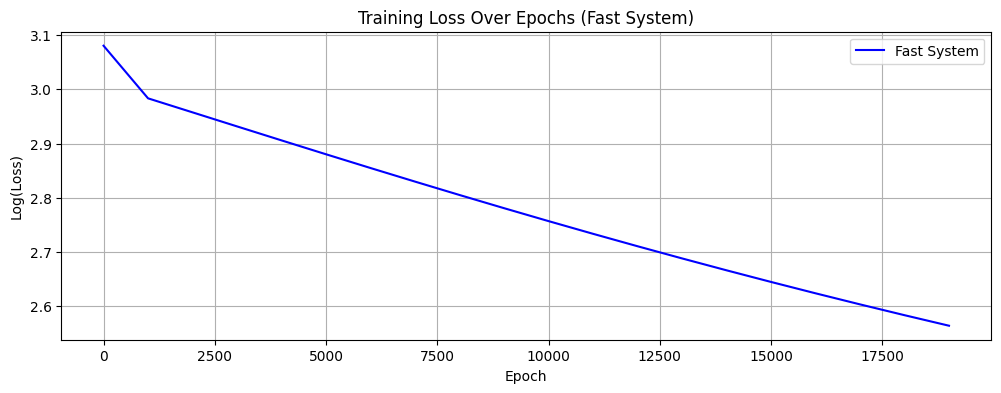

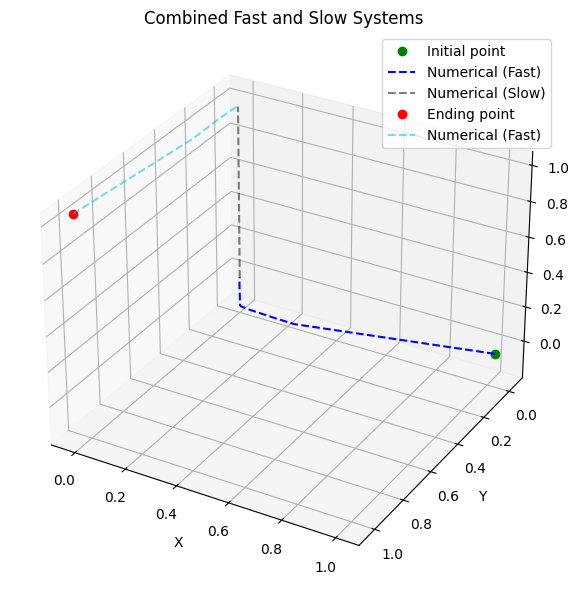

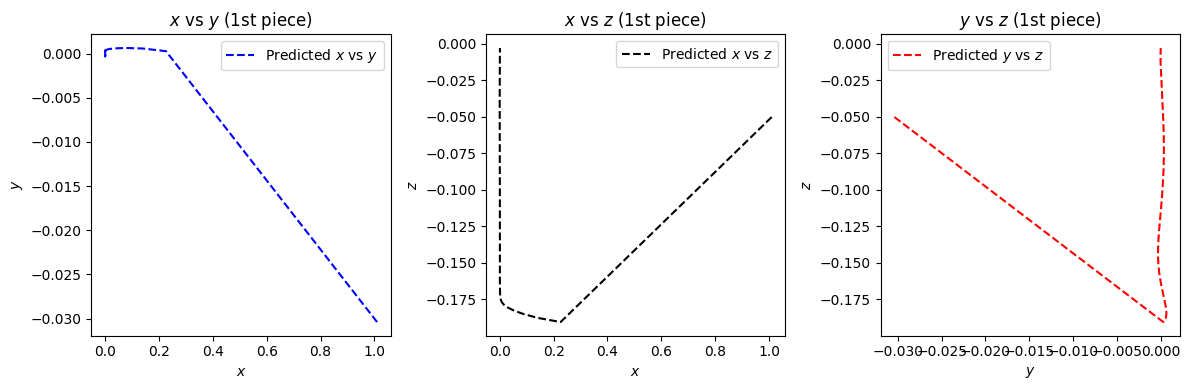

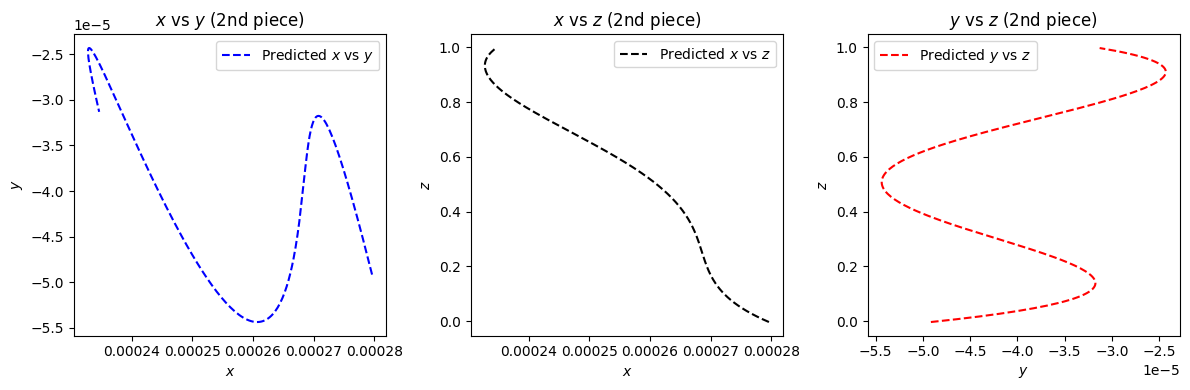

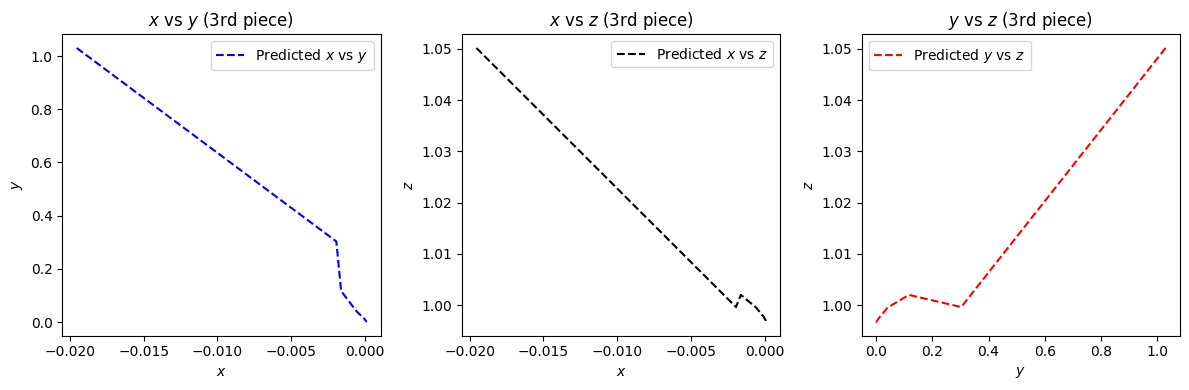

In [14]:
if __name__=='__main__':

    model_fast  = fast_system_PINN().to(torch.float64)  
    model_slow  = slow_system_PINN().to(torch.float64)
    model_fast2 = fast_system_PINN2().to(torch.float64) 

    optimizer = torch.optim.Adam(list(model_fast.parameters()) + list(model_slow.parameters()) + list(model_fast2.parameters()), lr=1e-3)
    loss_values = []
    epoch_num = 20000


    xf_end, yf_end, zf_end = np.random.random(), np.random.random(), np.random.random()    
    xf2_end, yf2_end, zf2_end = np.random.random(), np.random.random(), np.random.random()

    xs_init, ys_init, zs_init = np.random.random(), np.random.random(), np.random.random()
    xs_end, ys_end, zs_end = np.random.random(), np.random.random(), np.random.random()


    for epoch in range(epoch_num):
        optimizer.zero_grad()
        loss_total = total_loss_func(model_fast, model_slow, model_fast2,\
                                     t_tensor, tau_tensor, t2_tensor,\
                                     x_init, y_init, z_init, xf_end, yf_end, zf_end,\
                                     xs_init, ys_init, zs_init,\
                                     xs_end, ys_end, zs_end,\
                                     x_end, y_end, z_end, xf2_end, yf2_end, zf2_end, eps,\
                                     weight_fast=1.0, weight_slow=1.0)
        loss_total.backward()#(retain_graph=True)
        optimizer.step()
        with torch.no_grad():
            x_pred_fast, y_pred_fast, z_pred_fast = model_fast(t_tensor).numpy().T
            x_pred_slow, y_pred_slow, z_pred_slow = model_slow(tau_tensor).numpy().T
            x_pred_fast2, y_pred_fast2, z_pred_fast2 = model_fast2(t2_tensor).numpy().T

            xf_end,  yf_end,  zf_end  = x_pred_slow[0], y_pred_slow[0], z_pred_slow[0]
            xs_init, ys_init, zs_init = x_pred_fast[-1], y_pred_fast[-1], z_pred_fast[-1]
            xs_end,  ys_end,  zs_end  = x_pred_fast2[-1], y_pred_fast2[-1], z_pred_fast2[-1]
            xf2_end, yf2_end, zf2_end = x_pred_slow[-1],  y_pred_slow[-1],  z_pred_slow[-1]

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss_total.item()}')
            
            #print('xs_init, ys_init, zs_init are:', f"xs_init = {xs_init}, ys_init = {ys_init}, zs_init = {zs_init}")
            #print('xf_end, yf_end, zf_end are:', f"xf_end = {xf_end}, yf_end = {yf_end}, zf_end = {zf_end}")
            #print('xs_end, ys_end, zs_end are:', f"xs_end = {xs_end}, ys_end = {ys_end}, zs_end = {zs_end}")
            #print('xf2_end, yf2_end, zf2_end are:', f"xf2_end = {xf2_end}, yf2_end = {yf2_end}, zf2_end = {zf2_end}")

        loss_values.append(loss_total.item())
        
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.plot(range(0, epoch_num, 1000), np.log(loss_values[:epoch_num//1000]), 'b', label='Fast System')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.title('Training Loss Over Epochs (Fast System)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Model evaluation
    model_fast.eval()
    model_fast2.eval()
    model_slow.eval()
    with torch.no_grad():
        # Predictions for fast system
        x_pred_fast, y_pred_fast, z_pred_fast = model_fast(t_tensor).numpy().T
        # Predictions for slow system
        x_pred_slow, y_pred_slow, z_pred_slow = model_slow(tau_tensor).numpy().T
        # Predictions for fast system
        x_pred_fast2, y_pred_fast2, z_pred_fast2 = model_fast2(t2_tensor).numpy().T
        
    # Plotting the 3D trajectories
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot(x_init, y_init, z_init, 'go', label='Initial point')

    # Plotting fast system
    #ax.plot(x_exact_fast, y_exact_fast, z_exact_fast, 'b-', label='Exact (Fast)')
    ax.plot(x_pred_fast, y_pred_fast, z_pred_fast, 'b--', label='Numerical (Fast)')

    # Plotting slow system initial point
    #ax.plot(x_pred_fast[-1], y_pred_fast[-1], z_pred_fast[-1], 'go', label='Initial Point (Slow)')

    # Plotting slow system continuation
    #ax.plot(x_exact_slow + x_pred_fast[-1], y_exact_slow + y_pred_fast[-1], z_exact_slow + z_pred_fast[-1], 'g-', label='Exact (Slow)', alpha=0.5)
    ax.plot(x_pred_slow + x_pred_fast[-1],\
            y_pred_slow + y_pred_fast[-1],\
            z_pred_slow + z_pred_fast[-1], 'k--', label='Numerical (Slow)', alpha=0.5)

    # Plotting slow system initial point
    ax.plot(x_end, y_end, z_end, 'ro', label='Ending point')

    # Plotting fast system continuation
    #ax.plot(x_exact_fast2  , y_exact_fast2  , z_exact_fast2 , 'm-', label='Exact (Fast)', alpha=0.5)
    ax.plot(x_pred_fast2  , y_pred_fast2 , z_pred_fast2 , 'c--', label='Numerical (Fast)', alpha=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Combined Fast and Slow Systems')
    ax.legend()
    ax.invert_yaxis()

    plt.tight_layout()
    plt.show()
    
    
    

    
    # Plotting "x" vs "y", "x" vs "z", and "y" vs "z": over the 1st piece
    plt.figure(figsize=(12, 4))

    # "x" vs "y"
    plt.subplot(1, 3, 1)
    plt.plot(x_pred_fast, y_pred_fast, 'b--', label='Predicted $x$ vs $y$')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('$x$ vs $y$ (1st piece)')
    plt.legend()

    # "x" vs "z"
    plt.subplot(1, 3, 2)
    plt.plot(x_pred_fast, z_pred_fast, 'k--', label='Predicted $x$ vs $z$')
    plt.xlabel('$x$')
    plt.ylabel('$z$')
    plt.title('$x$ vs $z$ (1st piece)')
    plt.legend()

    # "y" vs "z"
    plt.subplot(1, 3, 3)
    plt.plot(y_pred_fast, z_pred_fast, 'r--', label='Predicted $y$ vs $z$')
    plt.xlabel('$y$')
    plt.ylabel('$z$')
    plt.title('$y$ vs $z$ (1st piece)')
    plt.legend()

    plt.tight_layout()
    plt.show()


    # Plotting "x" vs "y", "x" vs "z", and "y" vs "z": over the 2nd piece
    plt.figure(figsize=(12, 4))

    # "x" vs "y"
    plt.subplot(1, 3, 1)
    plt.plot(x_pred_slow, y_pred_slow, 'b--', label='Predicted $x$ vs $y$')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('$x$ vs $y$ (2nd piece)')
    plt.legend()

    # "x" vs "z"
    plt.subplot(1, 3, 2)
    plt.plot(x_pred_slow, z_pred_slow, 'k--', label='Predicted $x$ vs $z$')
    plt.xlabel('$x$')
    plt.ylabel('$z$')
    plt.title('$x$ vs $z$ (2nd piece)')
    plt.legend()

    # "y" vs "z"
    plt.subplot(1, 3, 3)
    plt.plot(y_pred_slow, z_pred_slow, 'r--', label='Predicted $y$ vs $z$')
    plt.xlabel('$y$')
    plt.ylabel('$z$')
    plt.title('$y$ vs $z$ (2nd piece)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plotting "x" vs "y", "x" vs "z", and "y" vs "z": over the 3rd piece
    plt.figure(figsize=(12, 4))

    # "x" vs "y"
    plt.subplot(1, 3, 1)
    plt.plot(x_pred_fast2, y_pred_fast2, 'b--', label='Predicted $x$ vs $y$')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('$x$ vs $y$ (3rd piece)')
    plt.legend()

    # "x" vs "z"
    plt.subplot(1, 3, 2)
    plt.plot(x_pred_fast2, z_pred_fast2, 'k--', label='Predicted $x$ vs $z$')
    plt.xlabel('$x$')
    plt.ylabel('$z$')
    plt.title('$x$ vs $z$ (3rd piece)')
    plt.legend()

    # "y" vs "z"
    plt.subplot(1, 3, 3)
    plt.plot(y_pred_fast2, z_pred_fast2, 'r--', label='Predicted $y$ vs $z$')
    plt.xlabel('$y$')
    plt.ylabel('$z$')
    plt.title('$y$ vs $z$ (3rd piece)')
    plt.legend()

    plt.tight_layout()
    plt.show()


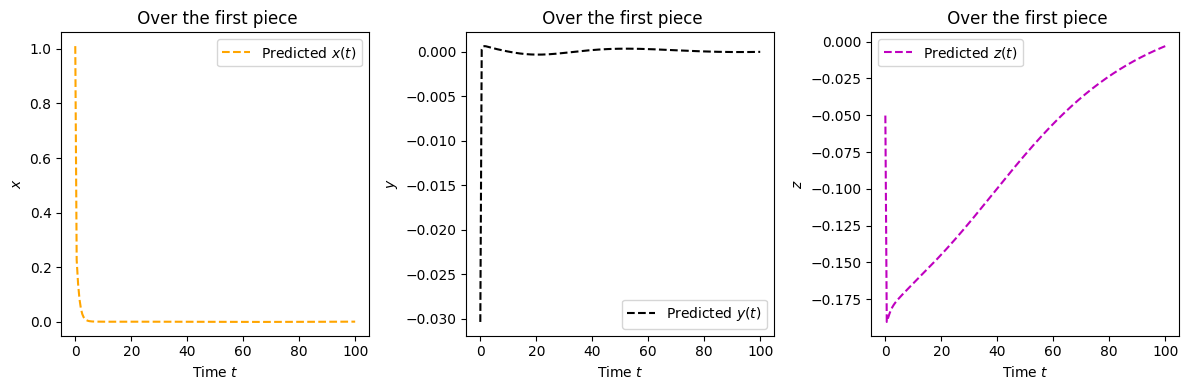

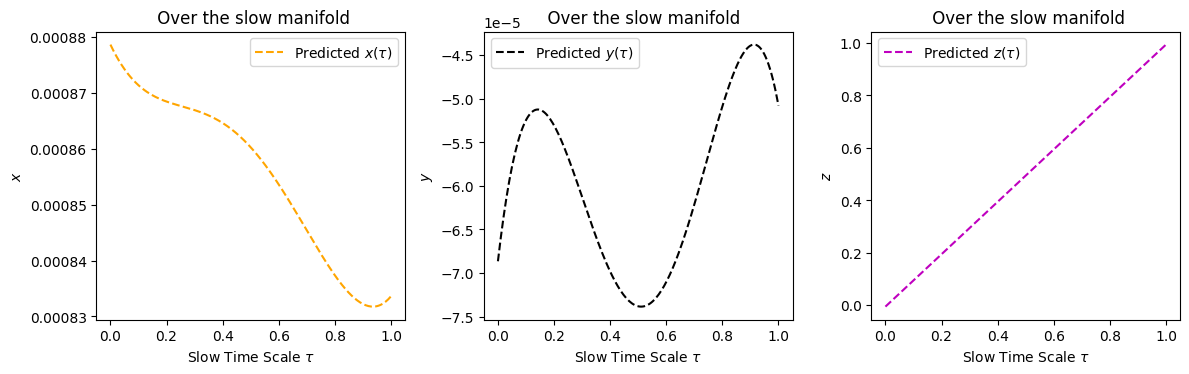

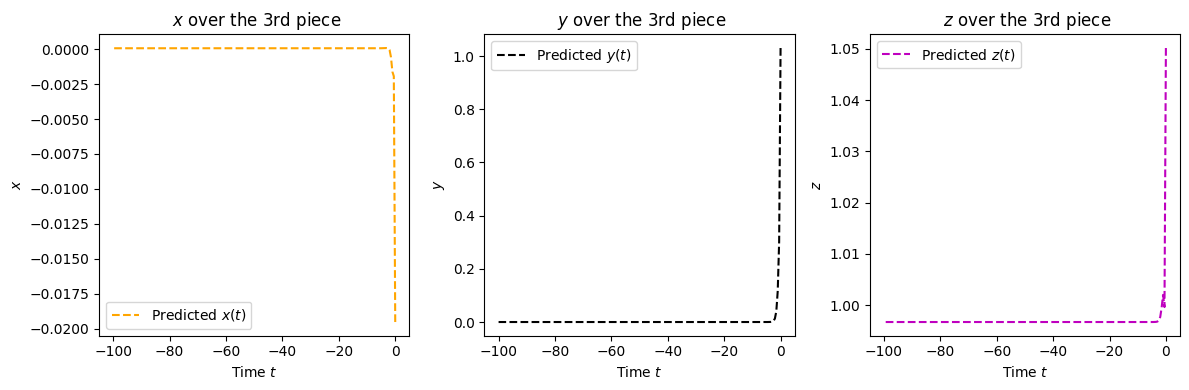

In [15]:
#########1st piece
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
#plt.plot(t, x_exact_fast, 'b-', label='Exact $x(t)$')
plt.plot(t, x_pred_fast, '--', color='orange', label='Predicted $x(t)$')
plt.xlabel('Time $t$')
plt.ylabel('$x$')
plt.title(' Over the first piece')
plt.legend()

plt.subplot(1, 3, 2)
#plt.plot(t, y_exact_fast, 'b-', label='Exact $y(t)$')
plt.plot(t, y_pred_fast, 'k--', label='Predicted $y(t)$')
plt.xlabel('Time $t$')
plt.ylabel('$y$')
plt.title(' Over the first piece')
plt.legend()

plt.subplot(1, 3, 3)
#plt.plot(t, z_exact_fast, 'b-', label='Exact $y(t)$')
plt.plot(t, z_pred_fast, 'm--', label='Predicted $z(t)$')
plt.xlabel('Time $t$')
plt.ylabel('$z$')
plt.title(' Over the first piece')
plt.legend()

# Adjust y-axis tick label formatting
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
ax.yaxis.offsetText.set_fontsize(10)  # Adjust font size as needed
ax.tick_params(axis='y', pad=5)  # Adjust the padding as needed


plt.tight_layout()
plt.show()

########2nd piece
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
#plt.plot(tau, x_exact_slow + x_exact_fast[-1], 'b-', label='Exact $x(t)$')
plt.plot(tau, x_pred_slow + x_pred_fast[-1], '--', color='orange', label='Predicted $x(\\tau)$')
plt.xlabel('Slow Time Scale $\\tau$')
plt.ylabel('$x$')
plt.title(' Over the slow manifold')
plt.legend()

plt.subplot(1, 3, 2)
#plt.plot(tau, y_exact_slow + y_exact_fast[-1], 'b-', label='Exact $y(t)$')
plt.plot(tau, y_pred_slow + y_pred_fast[-1], 'k--', label='Predicted $y(\\tau)$')
plt.xlabel('Slow Time Scale $\\tau$')
plt.ylabel('$y$')
plt.title('  Over the slow manifold')
plt.legend()

plt.subplot(1, 3, 3)
#plt.plot(tau, z_exact_slow + z_exact_fast[-1], 'g-', label='Exact $z(\\tau)$')
plt.plot(tau, z_pred_slow + z_pred_fast[-1], 'm--', label='Predicted $z(\\tau)$')
plt.xlabel('Slow Time Scale $\\tau$')
plt.ylabel('$z$')
plt.title(' Over the slow manifold')
plt.legend()

# Adjust y-axis tick label formatting
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
ax.yaxis.offsetText.set_fontsize(10)  # Adjust font size as needed
ax.tick_params(axis='y', pad=5)  # Adjust the padding as needed


plt.tight_layout()
plt.show()

########3rd piece
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
#plt.plot(t2, x_exact_fast2 , 'b-', label='Exact $x(t)$')
plt.plot(t2, x_pred_fast2 , '--', color='orange', label='Predicted $x(t)$')
plt.xlabel('Time $t$')
plt.ylabel('$x$')
plt.title(' $x$ over the 3rd piece')
plt.legend()

plt.subplot(1, 3, 2)
#plt.plot(t2, y_exact_fast2 , 'b-', label='Exact $y(t)$')
plt.plot(t2, y_pred_fast2 , 'k--', label='Predicted $y(t)$')
plt.xlabel('Time $t$')
plt.ylabel('$y$')
plt.title(' $y$ over the 3rd piece')
plt.legend()

plt.subplot(1, 3, 3)
#plt.plot(t2, z_exact_fast2  , 'g-', label='Exact $z(\\tau)$')
plt.plot(t2, z_pred_fast2 , 'm--', label='Predicted $z(t)$')
plt.xlabel('Time $t$')
plt.ylabel('$z$')
plt.title(' $z$ over the 3rd piece')
plt.legend()


plt.tight_layout()
plt.show()


In [16]:



print("xf_end type:", type(xf_end))
print(xf_end)

print("x_pred_fast[-1] type:", type(x_pred_fast[-1]))
#print("x_pred_fast[-1] shape:", x_pred_fast[-1].shape)
print(x_pred_fast[-1])
xf_end = x_pred_fast[-1]
print(xf_end)
print("xf_end type:", type(xf_end))



xf_end type: <class 'numpy.float64'>
0.0002796186392598349
x_pred_fast[-1] type: <class 'numpy.float64'>
0.0005989848149602905
0.0005989848149602905
xf_end type: <class 'numpy.float64'>


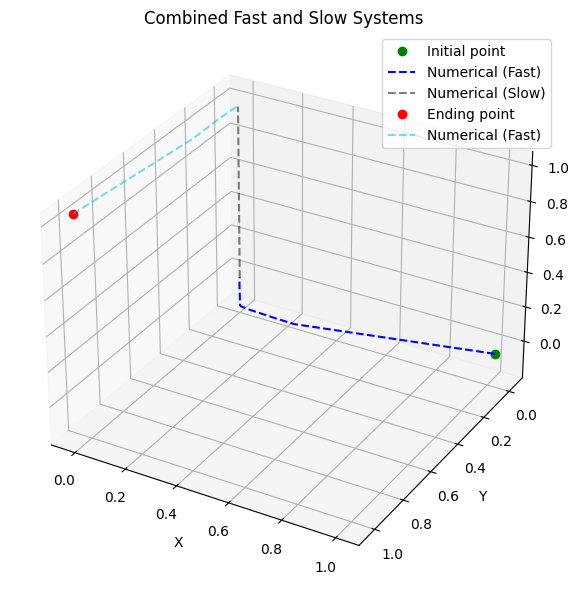

In [29]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x_init, y_init, z_init, 'go', label='Initial point')

ax.plot(x_pred_fast, y_pred_fast, z_pred_fast, 'b--', label='Numerical (Fast)')


ax.plot(x_pred_slow + x_pred_fast[-1],\
        y_pred_slow + y_pred_fast[-1],\
        z_pred_slow + z_pred_fast[-1], 'k--', label='Numerical (Slow)', alpha=0.5)

ax.plot(x_end, y_end, z_end, 'ro', label='Ending point')

ax.plot(x_pred_fast2  , y_pred_fast2 , z_pred_fast2 , 'c--', label='Numerical (Fast)', alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Combined Fast and Slow Systems')
ax.legend()
ax.invert_yaxis()

# Set bounds for x, y, and z-axes
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)
ax.set_zlim(0, 1.1)

# Rotating the figure by 20 degrees
ax.view_init(elev=20, azim=30)

plt.tight_layout()
plt.show()

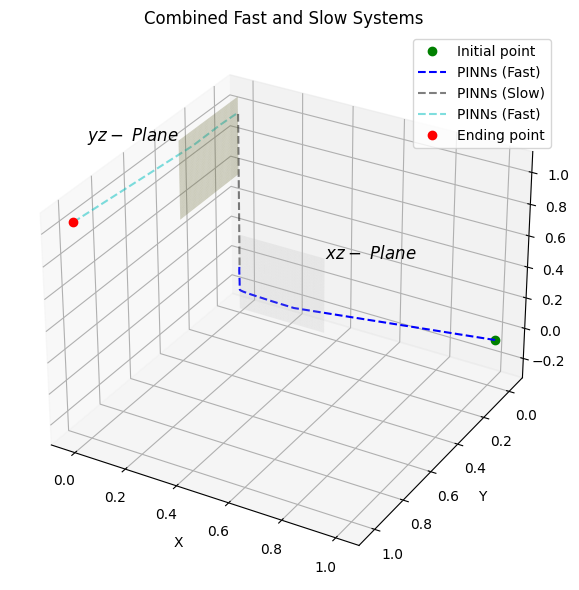

In [71]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting the xz-plane
x_plane = np.linspace(0, 0.35, 100)
z_plane = np.linspace(-0.3, 0.2, 100)
X_plane, Z_plane = np.meshgrid(x_plane, z_plane)
Y_plane = np.zeros_like(X_plane)  
ax.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.2, color='lightgrey')

# Plotting the yz-plane
y_plane = np.linspace(0, 0.4, 100)
z_plane = np.linspace(0.6, 1.1, 100)
Y_plane, Z_plane = np.meshgrid(y_plane, z_plane)
X_plane = np.zeros_like(Y_plane) 
ax.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.3,  color=(1.0, 1.0, 0.5))

# Annotation for xz-plane using LaTeX
ax.text(0.35, 0, 0.2, r"${xz-\ Plane}$", color='black', fontsize=12, ha='left')

# Annotation for yz-plane using LaTeX
ax.text(0, 0.4, 1.1, r"${yz-\ Plane}$", color='black', fontsize=12, ha='right')

# Your existing plots
ax.plot(x_init, y_init, z_init, 'go', label='Initial point')
ax.plot(x_pred_fast, y_pred_fast, z_pred_fast, 'b--', label='PINNs (Fast)')
ax.plot(x_pred_slow + x_pred_fast[-1], y_pred_slow + y_pred_fast[-1], z_pred_slow + z_pred_fast[-1], 'k--', label='PINNs (Slow)', alpha=0.5)
ax.plot(x_pred_fast2, y_pred_fast2, z_pred_fast2, 'c--', label='PINNs (Fast)', alpha=0.5)
ax.plot(x_end, y_end, z_end, 'ro', label='Ending point')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Combined Fast and Slow Systems')
ax.legend()
ax.invert_yaxis()

# Set bounds for x, y, and z-axes
#ax.set_xlim(0, 1.1)
#ax.set_ylim(0, 1.1)
#ax.set_zlim(0, 1.1)

# Rotating the figure by 20 degrees
#ax.view_init(elev=20, azim=-10)

plt.tight_layout()
plt.show()


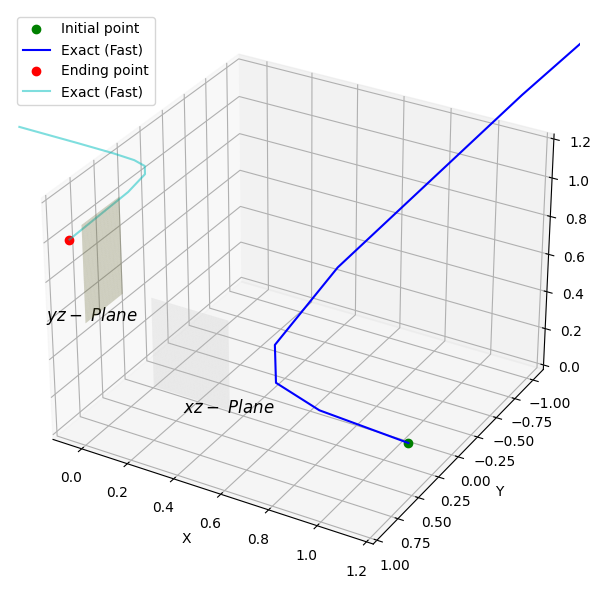

In [108]:
nn = 8
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x_init, y_init, z_init, 'go', label='Initial point')

# Plotting fast system
ax.plot(x_exact_fast[:nn], y_exact_fast[:nn], z_exact_fast[:nn], 'b-', label='Exact (Fast)')

# Plotting slow system initial point
ax.plot(x_end, y_end, z_end, 'ro', label='Ending point')

# Plotting fast system continuation
ax.plot(x_exact_fast2[:nn]  , y_exact_fast2[:nn]  , z_exact_fast2[:nn] , 'c-', label='Exact (Fast)', alpha=0.5)

# Plotting the xz-plane
x_plane = np.linspace(0-0.2, 0.35-0.2, 100)
z_plane = np.linspace(-0.3, 0.2, 100)
X_plane, Z_plane = np.meshgrid(x_plane, z_plane)
Y_plane = np.zeros_like(X_plane) -0.25
ax.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.2, color='lightgrey')

# Plotting the yz-plane
y_plane = np.linspace(0+0.55, 0.4+0.55, 100)
z_plane = np.linspace(0.6, 1.1, 100)
Y_plane, Z_plane = np.meshgrid(y_plane, z_plane)
X_plane = np.zeros_like(Z_plane) 
ax.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.3,  color=(1.0, 1.0, 0.5))

# Annotation for xz-plane using LaTeX
ax.text(0.35, 0+0.8, 0.2, r"${xz-\ Plane}$", color='black', fontsize=12, ha='left')

# Annotation for yz-plane using LaTeX
ax.text(0, 0.4, 1.1-0.7, r"${yz-\ Plane}$", color='black', fontsize=12, ha='right')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#ax.set_title('Combined Fast and Slow Systems')
ax.legend()
ax.invert_yaxis()

# Set bounds for x, y, and z-axes
ax.set_xlim(-.1, 1.2)
ax.set_ylim(1, -1.1)
ax.set_zlim(0, 1.2)

# Rotating the figure by 20 degrees
#ax.view_init(elev=20, azim=30)

plt.tight_layout()
plt.show()